# Lecture 7: PyTorch

In [101]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.inspection import DecisionBoundaryDisplay

def plot_boundary(model, X, y):
    xrange = (-X[:, 0].min() + X[:, 0].max()) / 10
    yrange = (-X[:, y].min() + X[:, y].max()) / 10
    feature_1, feature_2 = np.meshgrid(
        np.linspace(X[:, 0].min() - xrange, X[:, 0].max() + xrange),
        np.linspace(X[:, 1].min() - yrange, X[:, 1].max() + yrange)
    )
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    y_pred = np.reshape(model.predict(torch.tensor(grid).float()).detach().numpy(), feature_1.shape)
    display = DecisionBoundaryDisplay(
        xx0=feature_1, xx1=feature_2, response=y_pred
    )
    display.plot()
    display.ax_.scatter(
        X[:, 0], X[:, 1], c=y, edgecolor="black"
    )
    plt.show()

## Introduction to PyTorch

The most basic object in PyTorch is a `tensor`. Tensor objects behave much like the `AutogradValue` objects we are creating in the homework! We can create a `tensor` object with a given value as follows

In [16]:
x = torch.tensor(4.)
x

tensor(4.)

Performing basic operations on `tensor` objects gives tensor objects.

In [17]:
a = x ** 2 + 5
a

tensor(21.)

`tensor` objects also support reverse-mode automatic differentiation! To use this, we must specify that we will want to compute the derivative with respect to a given `tensor`. We can do this with the `requires_grad` argument.

In [18]:
x = torch.tensor(4., requires_grad=True)

Once we have a `tensor` that `requires_grad`, we can perform operations on it to compute a loss.

In [21]:
a = x ** 2 + 5
L = torch.log(a) # Functions like log must be called through torch
L

tensor(3.0445, grad_fn=<LogBackward0>)

Once we have a loss running the backward pass is done exactly as in the homework. First we call `backward()` on the loss `tensor` object, then we can access the derivative through the `grad` property of `x`.

In [25]:
L.backward()
x.grad

tensor(0.3810)

We can also create `tensor` objects that wrap arrays.

In [28]:
x = torch.tensor(np.array([3, 4, 5]))
x

tensor([3, 4, 5])

We can also just directly create tensors as we would numpy arrays

In [30]:
x = torch.tensor([3, 4, 5])
x

tensor([3, 4, 5])

Including convienience constructors.

In [32]:
print(torch.ones((5,)))
print(torch.zeros((2, 3)))

tensor([1., 1., 1., 1., 1.])
tensor([[0., 0., 0.],
        [0., 0., 0.]])


Automatic differentiation still works for arrays. In this case it gives use the gradient of the loss (hence the `grad` property).

In [36]:
x = torch.tensor([3., 4., 5.], requires_grad=True)
L = torch.sum(x ** 2)
L

tensor(50., grad_fn=<SumBackward0>)

In [37]:
L.backward()
x.grad

tensor([ 6.,  8., 10.])

We can convert `tensor` objects back to numpy by calling `x.detach().numpy()`. (`detach` removes the variable from any automatic differentiation computations)

In [83]:
x.detach().numpy()

array([1., 1., 1., 1., 1.], dtype=float32)

At this point it's probably worth remarking on where the name `tensor` comes from. 

So far we've discussed 3 kinds of array objects
- **Scalars:** which are just single values (0-dimensional)
- **Vectors:** 1-dimensional arrays of numbers
- **Matrices:** 2-dimensional arrays of numbers

![Alt text](image.png)

A **tensor** is the generalization of a vector or matrix to *any* number of dimensions. For example, a 3-dimensional tensor can be seen in multiple ways.

![Alt text](image-1.png)

A `tensor` object can be created with any number of dimensions. For example, we could create a 2x2x2 tensor as:

In [39]:
t = torch.tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])
t

tensor([[[1, 2],
         [3, 4]],

        [[5, 6],
         [7, 8]]])

Or we could create the tensor in the image using `arange` and `reshape`.

In [41]:
t = torch.arange(30).reshape((3, 2, 5))
t

tensor([[[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9]],

        [[10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19]],

        [[20, 21, 22, 23, 24],
         [25, 26, 27, 28, 29]]])

4-dimensional tensors can also be visualized

![Alt text](image-2.png)

In [43]:
t = torch.ones((3, 2, 4, 5))
t.shape

torch.Size([3, 2, 4, 5])

There are some notable differences between torch and numpy when it comes to operations. The important one to watch out for at this point is matrix multiplation. In numpy we accomplished with with `np.dot`:

In [170]:
x = np.ones((4, 5))
w = np.ones((5, 2))
np.dot(x, w)

array([[5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.]])

In PyTorch `torch.dot` only does vector dot products and thus only applies to 1-dimensional `tensor` objects:

In [171]:
x = torch.ones((4, 5))
w = torch.ones((5, 2))
torch.dot(x, w)

RuntimeError: 1D tensors expected, but got 2D and 2D tensors

Instead we use the `torch.matmul` function for this purpose

In [172]:
torch.matmul(x, w)

tensor([[5., 5.],
        [5., 5.],
        [5., 5.],
        [5., 5.]])

PyTorch also has many handy built-in functions that numpy doesn't have, such as `sigmoid`.

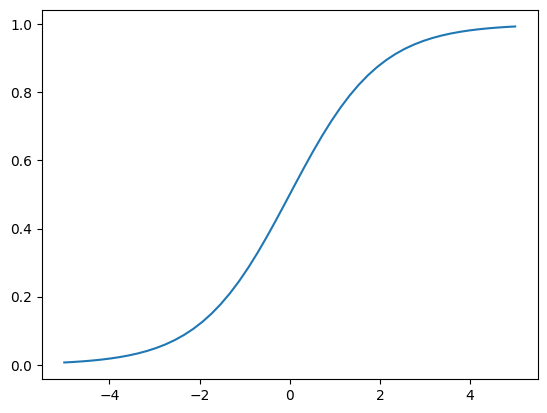

In [173]:
x = torch.linspace(-5, 5, 50)
s = torch.sigmoid(x)
plt.plot(x, s)

This makes it very easy to implement something like logistic regression. 

In [174]:
class LogisticRegression:
    def __init__(self, dims):
        self.weights = torch.ones((dims,), requires_grad=True)
        self.bias = torch.zeros((), requires_grad=True)

    def predict_probability(self, X):
        f_X = torch.matmul(X, self.weights) + self.bias
        return torch.sigmoid(f_X)

    def predict(self, X):
        self.predict_probability(X) > 0.5


Let's try loading a dataset, converting it to `tensor` and making predictions

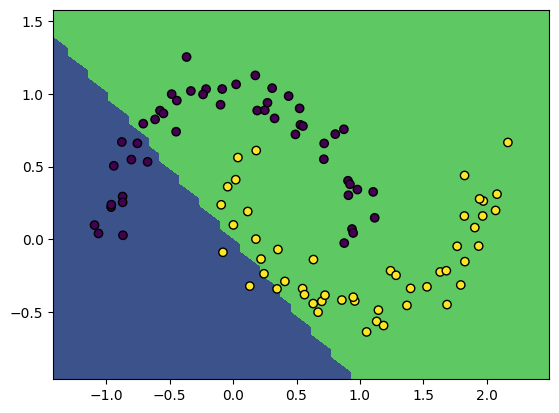

In [175]:
X, y = make_moons(noise=0.1)
X, y = torch.tensor(X).float(), torch.tensor(y)

model = LogisticRegression(2)
plot_boundary(model, X, y)

When working with PyTorch, it is convention to separate the loss function from the model, where the loss function will just take predictions and labels.

In [176]:
def NLL(pred, y):
    LL = y * torch.log(pred) + (1. - y) * torch.log(1. - pred)
    return -LL.sum()

## Gradient descent

Gradient descent is also implemented in PyTorch in the `optim` module.

In [177]:
from torch import optim

Gradient descent works a bit differently in PyTorch than what we've seen. We first need to construct a gradient descent *object* which specifies which values we're optimizing and what the learning rate will be. We specify the values to optimize by simply passing a list of weights/parameters to the constructor.

In PyTorch, basic gradient descent is encapsulated in the `optim.SGD` class (`SGD` stands for *stochastic gradient descent*, we'll talk about what *stochastic* means in this context next week.)

In [178]:
optimizer = optim.SGD([model.weights, model.bias], lr=0.1)

Notice that this object doesn't even take in the function we're trying to optimize, only the inputs. We need to call the function ourselves *and* run `backward()` to compute the gradients. 

In [179]:
predictions = model.predict_probability(X)
loss = NLL(predictions, y)
loss.backward()


Let's look at our model `weights`

In [180]:
model.weights

tensor([1., 1.], requires_grad=True)

We can take a single step of gradient descent using the `step` method of the optimizer.

In [181]:
optimizer.step()
model.weights

tensor([ 1.5771, -1.4567], requires_grad=True)

We see that this actually updates the weights themselves!

It's important to note that in PyTorch, calling `backward` does **not** clear the value stored in grad. So computing the gradient multiple times will result in updates to the gradient.

In [182]:
print(model.weights.grad)
NLL(model.predict_probability(X), y).backward()
print(model.weights.grad)
NLL(model.predict_probability(X), y).backward()
print(model.weights.grad)

tensor([-5.7714, 24.5667])
tensor([-16.5282,  28.3895])
tensor([-27.2850,  32.2123])


We can clear the stored gradients using the optimizer.

In [183]:
optimizer.zero_grad()
print(model.weights.grad)

None


So far we've only taking a single step of gradient descent. In order to run many steps, we need to write a loop to do everything we just saw.

In [184]:
for i in range(10):
    predictions = model.predict_probability(X)
    loss = NLL(predictions, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

47.09358596801758
43.22157669067383
34.15849304199219
31.948076248168945
30.564128875732422
29.81253433227539
29.332521438598633
29.01232147216797
28.785003662109375
28.61783218383789


We should now see that our model has been optimized!

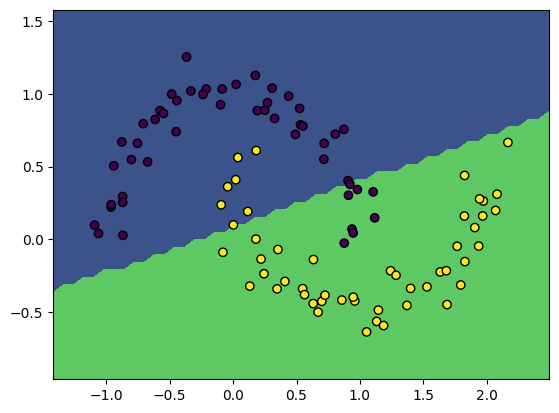

In [185]:
plot_boundary(model, X, y)

## torch.nn

While PyTorch as a tool for automatic differentiation and optimization would be useful by itself. It actually gives us a lot more than that!

On of the most important features of PyTorch is its model-building tools in the `torch.nn` module. This gives us a lot of powerful features that we can use to build complex neural networks!



In [186]:
from torch import nn

Let's start by building out logistic regression model in the `torch.nn` framwork. In order for a model to benefit from `torch.nn` our model class needs to inheret from `nn.Module`

In [192]:
class LogisticRegression(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.weights = nn.Parameter(torch.ones((dims,)))
        self.bias = nn.Parameter(torch.zeros(()))

    def forward(self, X):
        return torch.sigmoid(torch.matmul(X, self.weights) + self.bias)

    def predict_probability(self, X):
        return self.forward(X)

    def predict(self, X):
        return self.forward(X) > 0.5

There are 2 changes to note here. The first is that we wrapped our `weights` and `bias` terms in `nn.Parameter`. This tells PyTorch that these are the parameters we will want to optimize. We don't need to specify `requires_grad` for parameters, PyTorch will take care of that for us.

The second is that we moved the implmentation of `predict_probability` to `forward`. In PyTorch models the `forward` method is special, it defines the model as a function. If we call the model as a function `forward` will be called internally.

In [193]:
model = LogisticRegression(2)
model(X)

tensor([0.8061, 0.9062, 0.5295, 0.8793, 0.5760, 0.7457, 0.7801, 0.5451, 0.2699,
        0.6022, 0.8936, 0.7359, 0.8146, 0.7429, 0.3595, 0.6654, 0.8362, 0.5015,
        0.5419, 0.7889, 0.8034, 0.7207, 0.7751, 0.8122, 0.3505, 0.3228, 0.6957,
        0.5209, 0.6943, 0.8058, 0.7483, 0.5522, 0.7572, 0.5012, 0.5702, 0.9059,
        0.8479, 0.5518, 0.7708, 0.7704, 0.5722, 0.6250, 0.4369, 0.8790, 0.5790,
        0.6379, 0.4764, 0.5471, 0.7326, 0.4577, 0.9034, 0.7895, 0.6305, 0.6588,
        0.6457, 0.4482, 0.7797, 0.7687, 0.8219, 0.9444, 0.5676, 0.6338, 0.5766,
        0.8070, 0.3013, 0.7863, 0.6884, 0.7908, 0.7290, 0.7986, 0.5785, 0.6059,
        0.7611, 0.8420, 0.6813, 0.6439, 0.7005, 0.7083, 0.5252, 0.4524, 0.2647,
        0.7873, 0.5357, 0.5840, 0.9021, 0.6080, 0.7858, 0.7382, 0.7141, 0.9162,
        0.5217, 0.7707, 0.7938, 0.6209, 0.4647, 0.6258, 0.3928, 0.3268, 0.5453,
        0.8687], grad_fn=<SigmoidBackward0>)

This means that we can use instances of `nn.Module` as parameterized functions. For example, we might create a general linear (technically affine) function in the same way.

$$f(\mathbf{x}) = \mathbf{x}^T\mathbf{W}^T + \mathbf{b},  \quad f: \mathbb{R}^i \rightarrow \mathbb{R}^o$$

Note that here we are **not** assuming an augmented representation of $\mathbf{x}$.

In [195]:
class Linear(nn.Module):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.weightsT = nn.Parameter(torch.ones((inputs, outputs)))
        self.bias = nn.Parameter(torch.zeros((outputs,)))

    def forward(self, X):
        return torch.matmul(X, self.weightsT) + self.bias

We can use this module to implement out logistic regression model above.

In [200]:
class LogisticRegression(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.linear = Linear(dims, 1)                       # Dims input 1 output

    def forward(self, X):
        return torch.sigmoid(self.linear(X)).reshape((-1,)) # Turn output into a vector

    def predict_probability(self, X):
        return self.forward(X)

    def predict(self, X):
        return self.forward(X) > 0.5

In [201]:
model = LogisticRegression(2)
model(X)

tensor([0.8061, 0.9062, 0.5295, 0.8793, 0.5760, 0.7457, 0.7801, 0.5451, 0.2699,
        0.6022, 0.8936, 0.7359, 0.8146, 0.7429, 0.3595, 0.6654, 0.8362, 0.5015,
        0.5419, 0.7889, 0.8034, 0.7207, 0.7751, 0.8122, 0.3505, 0.3228, 0.6957,
        0.5209, 0.6943, 0.8058, 0.7483, 0.5522, 0.7572, 0.5012, 0.5702, 0.9059,
        0.8479, 0.5518, 0.7708, 0.7704, 0.5722, 0.6250, 0.4369, 0.8790, 0.5790,
        0.6379, 0.4764, 0.5471, 0.7326, 0.4577, 0.9034, 0.7895, 0.6305, 0.6588,
        0.6457, 0.4482, 0.7797, 0.7687, 0.8219, 0.9444, 0.5676, 0.6338, 0.5766,
        0.8070, 0.3013, 0.7863, 0.6884, 0.7908, 0.7290, 0.7986, 0.5785, 0.6059,
        0.7611, 0.8420, 0.6813, 0.6439, 0.7005, 0.7083, 0.5252, 0.4524, 0.2647,
        0.7873, 0.5357, 0.5840, 0.9021, 0.6080, 0.7858, 0.7382, 0.7141, 0.9162,
        0.5217, 0.7707, 0.7938, 0.6209, 0.4647, 0.6258, 0.3928, 0.3268, 0.5453,
        0.8687], grad_fn=<ReshapeAliasBackward0>)

The power here is that because `Linear` is also an instance of `nn.Module`, PyTorch knows that it's weights should also be considered part of our models weights. We can access the weights of a model using the `parameters()` method.

In [203]:
list(model.parameters())

[Parameter containing:
 tensor([[1.],
         [1.]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True)]

This lets us easily apply gradient descent:

In [204]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

for i in range(10):
    predictions = model(X)        # Now we can just call model!
    loss = NLL(predictions, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

76.70811462402344
47.09358596801758
43.22157669067383
34.15849304199219
31.948076248168945
30.564128875732422
29.81253433227539
29.332521438598633
29.01232147216797
28.785003662109375


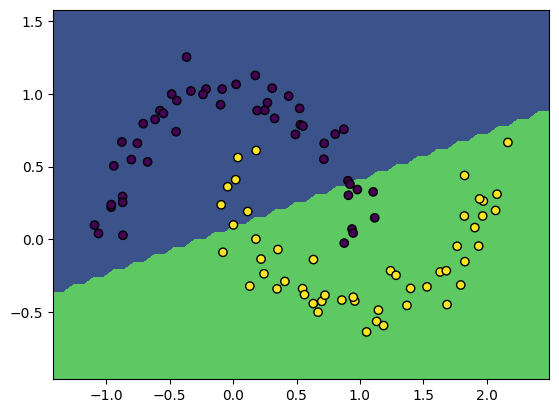

In [205]:
plot_boundary(model, X, y)

PyTorch unsurprisingly also provides a built-in `Linear` module. As `nn.Linear`.

In [206]:
nn.Linear(2, 1)

Linear(in_features=2, out_features=1, bias=True)

Knowing how to make a parameterized function in PyTorch, let's consider making a neural network layer with a sigmoid activation function.

$$f(\mathbf{x}) = \sigma(\mathbf{x}^T\mathbf{W}^T + \mathbf{b})$$

In [210]:
class SigmoidLayer(nn.Module):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.linear = nn.Linear(inputs, outputs)

    def forward(self, X):
        return torch.sigmoid(self.linear(X))
        

Let's create a layer with 10 neurons. (So $\mathbf{W}:\ (10 \times 2)$)

In [212]:
layer = SigmoidLayer(2, 10)
print(X.shape)
layer(X).shape

torch.Size([100, 2])


torch.Size([100, 10])

Let's use this to create a neural network class for binary classification!

In [219]:
class NeuralNetwork(nn.Module):
    def __init__(self, dims, hidden_size):
        super().__init__()
        self.layer = SigmoidLayer(dims, hidden_size)
        self.linear = Linear(hidden_size, 1)                       

    def forward(self, X):
        hidden_neurons = self.layer(X)
        output = self.linear(hidden_neurons)
        return torch.sigmoid(output).reshape((-1,))

    def predict_probability(self, X):
        return self.forward(X)

    def predict(self, X):
        return self.forward(X) > 0.5

We see that PyTorch recognizes both the parameters of the logistic regression and the parameters of our neural network feature transform:

In [220]:
model = NeuralNetwork(2, 10)
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2096, -0.3608],
         [-0.4380, -0.6813],
         [ 0.3196,  0.4796],
         [-0.4256, -0.6939],
         [ 0.4838,  0.3606],
         [-0.0805,  0.5008],
         [-0.2017,  0.4119],
         [ 0.2697,  0.4036],
         [ 0.5785,  0.2659],
         [-0.6341,  0.1310]], requires_grad=True),
 Parameter containing:
 tensor([-0.0678, -0.6714, -0.4546, -0.4149, -0.3568,  0.7036,  0.4120, -0.6844,
          0.1531,  0.3548], requires_grad=True),
 Parameter containing:
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True)]

This means that we can easily run our optimization as before.

In [223]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

for i in range(100):
    predictions = model(X)        # Now we can just call model!
    loss = NLL(predictions, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

45.445369720458984
43.70785903930664
47.474220275878906
40.63535690307617
42.115936279296875
36.09637451171875
36.04859161376953
32.92196273803711
32.511871337890625
30.93625831604004
30.521907806396484
29.64164924621582
29.293277740478516
28.74832534790039
28.467708587646484
28.101655960083008
27.878223419189453
27.618236541748047
27.442567825317383
27.252187728881836
27.116464614868164
26.97370719909668
26.86859893798828
26.755901336669922
26.669967651367188
26.572307586669922
26.494722366333008
26.40076446533203
26.323572158813477
26.225831985473633
26.144067764282227
26.0379695892334
25.94887924194336
25.831634521484375
25.73374366760254
25.603410720825195
25.4957332611084
25.350324630737305
25.231674194335938
25.068439483642578
24.936925888061523
24.7518253326416
24.604541778564453
24.391887664794922
24.22479820251465
23.97708511352539
23.785263061523438
23.49335289001465
23.272056579589844
22.926254272460938
22.673450469970703
22.265865325927734
21.986351013183594
21.513706207275

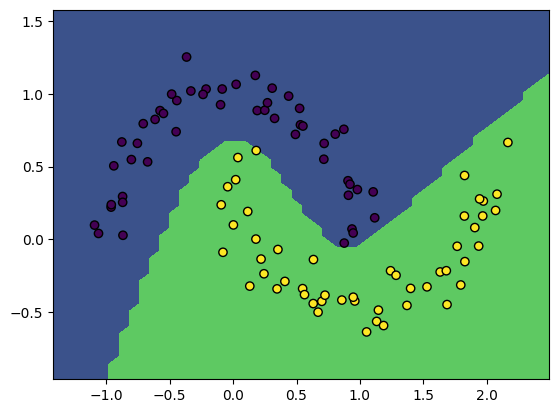

In [224]:
plot_boundary(model, X, y)

PyTorch also gives us an easier (but less flexible) way to define a composition of modules like this. In PyTorch we can define this simple network using `nn.Sequential`

In [229]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)
model(X).reshape((-1,))

Here `nn.Sigmoid` is a built-in module that just applies the sigmoid function. Its implementation would look like:

In [241]:
class SigmoidLayer(nn.Module):
    def forward(self, X):
        return torch.sigmoid(X)

We could use this to create a network with several hidden layers:

In [238]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.Sigmoid(),
    nn.Linear(10, 10),
    nn.Sigmoid(),
    nn.Linear(10, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)
model(X)

tensor([[0.5571],
        [0.5571],
        [0.5575],
        [0.5571],
        [0.5574],
        [0.5572],
        [0.5572],
        [0.5574],
        [0.5576],
        [0.5574],
        [0.5571],
        [0.5573],
        [0.5572],
        [0.5573],
        [0.5575],
        [0.5572],
        [0.5571],
        [0.5575],
        [0.5575],
        [0.5571],
        [0.5572],
        [0.5571],
        [0.5573],
        [0.5572],
        [0.5575],
        [0.5575],
        [0.5572],
        [0.5574],
        [0.5572],
        [0.5571],
        [0.5571],
        [0.5573],
        [0.5571],
        [0.5575],
        [0.5574],
        [0.5570],
        [0.5572],
        [0.5574],
        [0.5572],
        [0.5571],
        [0.5573],
        [0.5572],
        [0.5574],
        [0.5571],
        [0.5573],
        [0.5574],
        [0.5574],
        [0.5575],
        [0.5573],
        [0.5575],
        [0.5571],
        [0.5572],
        [0.5574],
        [0.5574],
        [0.5573],
        [0

PyTorch also provides built-in loss functions. The PyTorch function for the negative log-likelihood for logistic regression is called `nn.functional.binary_cross_entropy`. It has some sharp edges though. 

For one, it expects `y` to be a float type. We can convert a PyTorch `int` tensor into a `float` one by calling the `float` method.

We also see that our sequential model returns a column vector, so `y` should match that as well.

In [240]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

yfloat = y.float().reshape((-1, 1))

for i in range(100):
    predictions = model(X)        # Now we can just call model!
    loss = nn.functional.binary_cross_entropy(predictions, yfloat)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

0.6996942162513733
0.6985191106796265
0.6975520253181458
0.6967566013336182
0.6961024403572083
0.6955646276473999
0.6951226592063904
0.6947595477104187
0.6944611072540283
0.6942159533500671
0.6940144896507263
0.6938489675521851
0.6937129497528076
0.6936012506484985
0.6935093402862549
0.6934338212013245
0.6933718323707581
0.6933207511901855
0.6932787299156189
0.6932441592216492
0.6932157278060913
0.6931923031806946
0.6931729316711426
0.6931568384170532
0.6931436061859131
0.6931325793266296
0.693123459815979
0.6931159496307373
0.6931095123291016
0.6931042671203613
0.6930997371673584
0.6930959224700928
0.6930928230285645
0.6930900812149048
0.693087637424469
0.6930855512619019
0.6930838227272034
0.6930822134017944
0.6930808424949646
0.6930795907974243
0.6930783987045288
0.6930773258209229
0.6930763721466064
0.6930754780769348
0.6930745840072632
0.6930738091468811
0.6930729746818542
0.6930721998214722
0.6930714249610901
0.6930708289146423
0.6930701732635498
0.6930694580078125
0.693068742752

For convinience, let's definie a wrapper class for our model.

In [266]:
class LogisticRegressionNeuralNetwork(nn.Module):
    def __init__(self, network):
        super().__init__()
        self.network = network                   

    def forward(self, X):
        return self.network(X).reshape((-1,))

    def predict_probability(self, X):
        return self.forward(X)

    def predict(self, X):
        return self.forward(X) > 0.5

## Evaluating models

We see that we have a *lot* of options when designing a neural network. So far the choices we've seen are:
- The number of layers
- The number of neurons in each layer
- The activation function
- The learning rate for gradient descent

And this is just the beginning! As we go on, we'll learn about many more options that we have.

Let's take a look at how to make some of these choices. In many real cases, our data will not be a cleanly separated into 2 classes as we've seen. For instance, we can look at a noisier version of the dataset we saw before.

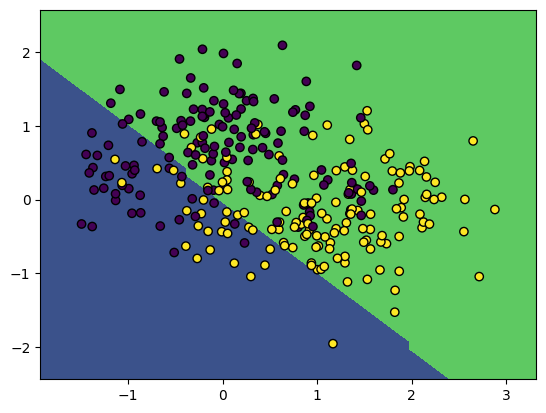

In [289]:
X, y = make_moons(300, noise=0.5)
X, y = torch.tensor(X).float(), torch.tensor(y)


model = LogisticRegression(2)
plot_boundary(model, X, y)

Let's split this into training and test sets as we've seen.

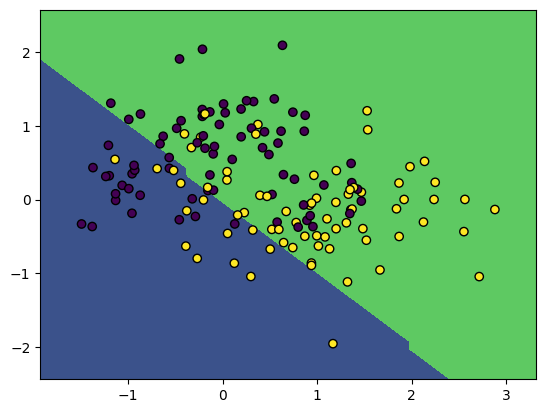

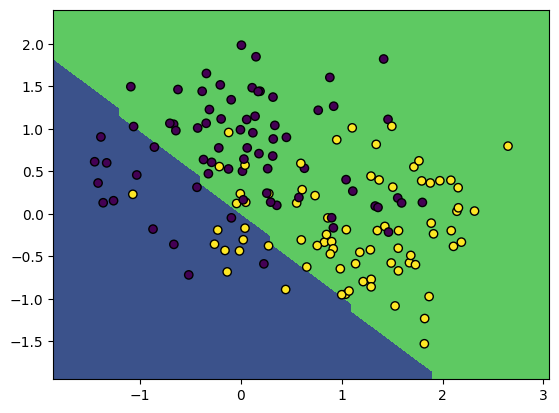

In [290]:
inds = np.arange(X.shape[0])
np.random.shuffle(inds)
Xtrain, ytrain = X[inds[:150]], y[inds[:150]]
Xtest, ytest = X[inds[150:]], y[inds[150:]]
plot_boundary(model, Xtrain, ytrain)
plot_boundary(model, Xtest, ytest)

We'll start by fitting a logistic regression model as we've seen.

In [291]:
network = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid(),
)
model = LogisticRegressionNeuralNetwork(network)   

optimizer = optim.SGD(model.parameters(), lr=0.1)

for i in range(500):
    predictions = model(Xtrain)        # Now we can just call model!
    loss = NLL(predictions, ytrain.flatten())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

120.94316864013672
127.796875
86.81439971923828
73.72380065917969
72.54862976074219
72.56034088134766
73.04600524902344
75.56434631347656
84.96688842773438
124.48078155517578
118.78359985351562
151.2896728515625
93.05940246582031
83.9063720703125
83.98695373535156
110.54647064208984
113.08613586425781
155.552490234375
96.2688217163086
87.4237060546875
85.07091522216797
111.030029296875
111.80404663085938
152.46817016601562
96.31392669677734
88.99681091308594
86.41571044921875
114.03663635253906
111.0711898803711
147.8506317138672
95.83660888671875
90.59500885009766
88.1241683959961
117.94168090820312
110.042236328125
141.86573791503906
95.25202941894531
93.01756286621094
90.48155212402344
122.63541412353516
108.35640716552734
134.02325439453125
94.65928649902344
97.04625701904297
93.74947357177734
127.61271667480469
105.7712631225586
124.43855285644531
94.2139663696289
103.38475036621094
97.69415283203125
130.93934631347656
102.47567749023438
115.14863586425781
94.21851348876953
111.37

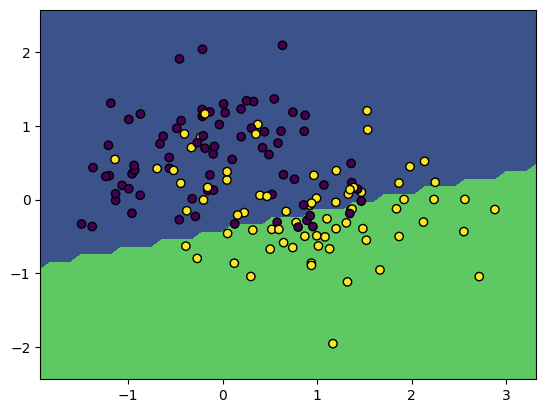

In [292]:
plot_boundary(model, Xtrain, ytrain)

Let's compute the accuracy on both the training and the test data

In [293]:
train_acc = (model.predict(Xtrain) == ytrain).float().mean()
test_acc = (model.predict(Xtest) == ytest).float().mean()
print('Training accuracy: %.3f, Test accuracy: %.3f' % (train_acc, test_acc))

Training accuracy: 0.713, Test accuracy: 0.760


In [313]:
network = nn.Sequential(
    nn.Linear(2, 250),
    nn.ReLU(),
    nn.Linear(250, 250),
    nn.ReLU(),
    nn.Linear(250, 250),
    nn.ReLU(),
    nn.Linear(250, 250),
    nn.ReLU(),
    nn.Linear(250, 1),
    nn.Sigmoid(),
)
model = LogisticRegressionNeuralNetwork(network)   

optimizer = optim.SGD(model.parameters(), lr=0.00001)

for i in range(25000):
    predictions = model(Xtrain)        # Now we can just call model!
    loss = NLL(predictions, ytrain.flatten())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #print(loss.item())

KeyboardInterrupt: 

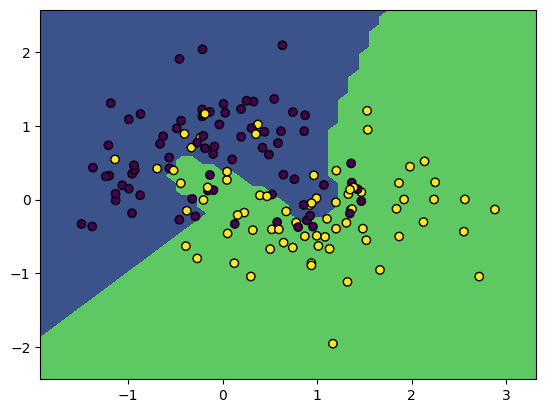

In [310]:
plot_boundary(model, Xtrain, ytrain)